In [3]:
import sys

sys.path.append('..')

from src.configs import DataConfig, NetConfig, NetArchitecture, FilterConfig, DataType
from src.utils import train, get_wandb_logger
from src.configs import PACKAGE_PATH
from src.data.data_processor import DataProcessor

# DataLoader

In [4]:
filter=FilterConfig(
    n_bins= 30,
    n_gaps= 10,
    gap_size= 5, 
    rms_ratio= 0.,
    non_zero_ratio=0.8
)

data_config = DataConfig(
    path="/mnt/c/work/Fall_2021_csv",
    output_path=f"{PACKAGE_PATH}/resources/datasets",
    # class_names=["cz_3", "falcon_9", "atlas_V",  "h2a", "globalstar"],
    # regexes=[r'CZ-3B.*', r'FALCON_9.*', r'ATLAS_[5|V]_CENTAUR_R_B$',  r'H-2A.*', r'GLOBALSTAR.*'],
    class_names=["h2a", "globalstar"],
    regexes=[r'H-2A.*', r'GLOBALSTAR.*'],
    validation_split=0.2,
    split_strategy="objectID",
    number_of_training_examples_per_class=10_000,
    filter_config=filter,
    convert_to_mag=False,
    wavelet_scales= 10,
    wavelet_name= 'gaus1',
    data_types=[DataType.LC]
)

In [5]:
dp = DataProcessor(data_config)
dp.create_dataset_from_csv()
dp._compute_wavelet_transform()
dp.save_data()
# dp.load_raw_data_MMT()
# dp.save_data_MMT()

Reading csv files....


100%|██████████| 431/431 [00:01<00:00, 348.18it/s] 


Computing Fourier Series....


100%|██████████| 6831/6831 [00:37<00:00, 180.92it/s]


In [8]:
lc = dp.data[DataType.LC]
dp._compute_wavelet_transform(lc, len(lc))

Computing Continuous Wavelet Transform....


In [9]:
dp._save_data_type(DataType.WAVELET)

In [10]:
path = f"{dp.output_path}/{dp.hash}"
for t in dp.data:
    print(t, dp.data[t].shape)
    

labels (6831,)
headers (6831, 3)
light_curve (6831, 300)
fourier_series_coefs (6831, 17)
fourier_series_std (6831, 17)
amplitude (6831, 1)
residuals (6831, 300)
reconstructed_lc (6831, 300)
rms (6831, 1)
wavelet_transform (6831, 3000)


In [4]:
for t in dp.data:
    if dp.data[t] is not None:
        print(t, dp.data[t].shape)

labels (6831,)
headers (6831, 3)
light_curve (6831, 300)
fourier_series_coefs (6831, 17)
fourier_series_std (6831, 17)
amplitude (6831, 1)
residuals (6831, 300)
reconstructed_lc (6831, 300)
rms (6831, 1)


In [7]:
train_set, val_set = dp.get_pytorch_datasets()
from collections import Counter
print(Counter(train_set.labels), Counter(val_set.labels))
print(len(train_set), len(val_set))


AttributeError: 'DataProcessor' object has no attribute 'examples'

# Lightning module

In [6]:
import sys
sys.path.append('..')

from src_refactored.configs import NetConfig, NetArchitecture, FCConfig, CNNConfig, CNNFCConfig, PACKAGE_PATH
from src_refactored.configs import ModelConfig
from src_refactored.module.fc import FC
from src_refactored.module.cnn import CNN
from src_refactored.module.cnnfc import CNNFC
from src_refactored.module.lightning_module import LCModule

from src_refactored.utils import train, get_wandb_logger

In [7]:
# net_cfg = NetConfig(
#     name="default",
#     input_size=300,
#     class_names=data_config.class_names,
#     output_size=5,
#     architecture=NetArchitecture.FC,
#     args=FCConfig(input_size=300, output_size=5, layers=[])  
# )
net_cfg = NetConfig(
    name="default",
    input_size=300,
    class_names=data_config.class_names,
    output_size=5,
    architecture=NetArchitecture.CNN,
    args=CNNConfig(input_size=300, 
                   output_size=5,
                   in_channels=data_config.wavelet_scales,
                   conv_layers=[(5, 11, 3)],
                   classifier_layers=[256])
)

In [8]:
module = LCModule(net_cfg)


CNN middle dim: 250


In [9]:
logger = get_wandb_logger("LC")
logger = None
train(module, dp, 3, 16,4, logger=logger)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dano-kyselica. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/poirot/.netrc
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | CNN              | 66.1 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
66.1 K    Trainable params
0         Non-trainable params
66.1 K    Total params
0.264     Total esti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


# Wavelets transform    

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

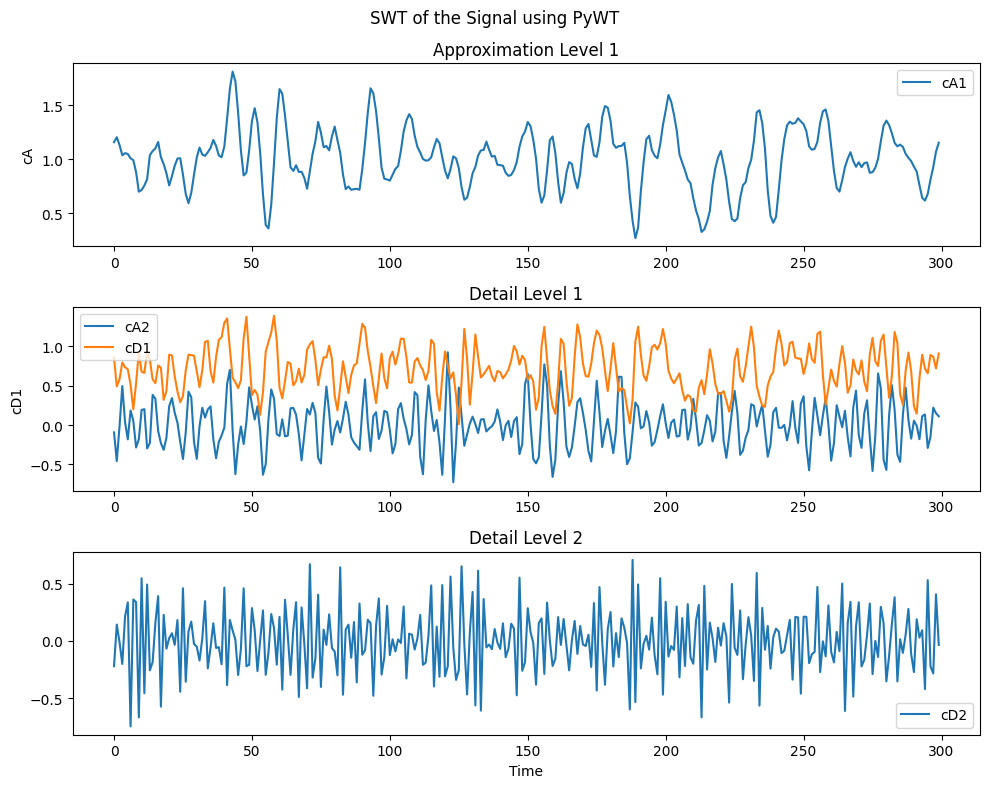

In [11]:
level = 2   
signal = np.random.rand(300)
wavelet = pywt.Wavelet('db4')
cA, cD = pywt.swt(signal, wavelet, level=level)

cA_list = []
cD_list = []
for i in range(level):
    cA_list.append(cA[i])
    cD_list.append(cD[i])
# Extract frequencies associated with each level
scales = np.arange(1, level + 1)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=level + 1, figsize=(10, 8))

# Plot approximation coefficient at each level
for i, ax in enumerate(axes[:-1]):
    ax.plot(cA_list[i], label=f'cA{i+1}')
    ax.set_title(f'Approximation Level {i+1}')
    ax.legend()

# Plot detail coefficients at each level
for i, ax in enumerate(axes[1:]):
    ax.plot(cD_list[i], label=f'cD{i+1}')
    ax.set_title(f'Detail Level {i+1}')
    ax.legend()

# Set labels and title for the overall plot
axes[-1].set_xlabel('Time')
axes[0].set_ylabel('cA')
axes[1].set_ylabel('cD1')
fig.suptitle('SWT of the Signal using PyWT')

# Customize plot appearance as needed (e.g., grid, limits)
plt.tight_layout()
plt.show()


In [15]:
# x = np.arange(300)*2*np.pi/300
# y = np.sin(x)
# y = np.roll(y, 10)
y = np.random.rand(4, 300)
# plt.plot(x, y)
coef, freqs=pywt.cwt(y,np.arange(1,10),'gaus1')
coef2 = [pywt.cwt(yy, np.arange(1,10), 'gaus1')[0] for yy in y]
# plt.matshow(coef)
print(coef.shape, np.max(coef), np.min(coef))

(9, 4, 300) 1.529625483653227 -1.5796591847588717


In [19]:
coef3 = coef.transpose(1,0,2)
xxx = coef3.reshape(4, -1).reshape(4, 9, 300)
# xxx = coef3.flatten().reshape(4,9, 300)
np.all(xxx == coef3)
# coef3[0,1,:20], xxx[0,1,:20]

True

In [14]:
coef3.shape, xxx.shape


((4, 9, 300), (4, 9, 300))